# Big Brother - Healthcare edition

### Building a classifier using the [fastai](https://www.fast.ai/) library 

In [1]:
from fastai.tabular import *

In [2]:
#hide
path = Path('./covid19_ml_education')

In [17]:
df = pd.read_csv(path/'covid_ml.csv')

In [18]:
df.head(3)

,ID,age,sex,cough,fever,chills,sore_throat,headache,fatigue,urgency_of_admission,...,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,date_death_or_discharge,source
0,1,30.0,male,No,No,No,No,No,No,Low,...,Anhui,China,31.646960,117.716600,admin3,2020-01-18,2020-01-20,2020-01-22,NaN,http://ah.people.com.cn/GB/n2/2020/0127/c35826...
1,2,47.0,male,No,No,No,No,No,No,Low,...,Anhui,China,31.778630,117.331900,admin3,2020-01-10,2020-01-21,2020-01-23,NaN,http://ah.people.com.cn/GB/n2/2020/0127/c35826...
2,3,49.0,male,No,No,No,No,No,No,Low,...,Anhui,China,31.828313,117.224844,point,2020-01-15,2020-01-20,2020-01-23,NaN,http://ah.people.com.cn/GB/n2/2020/0127/c35826...


## Independent variable

This is the value we want to predict

In [19]:
y_col = 'urgency_of_admission'

## Dependent variable

The values on which we can make a prediciton

In [20]:
cat_names = ['sex', 'cough', 'fever', 'chills', 'sore_throat', 'headache', 'fatigue']

In [21]:
cat_names = ['sex', 'cough', 'fever', 'headache', 'fatigue']

In [22]:
cont_names = ['age']

In [23]:
#hide
procs = [FillMissing, Categorify, Normalize]

In [148]:
#hide
test = TabularList.from_df(df.iloc[660:861].copy(), path = path, cat_names= cat_names, cont_names = cont_names)

In [24]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs = procs)
         .split_by_rand_pct(0.2)
         .label_from_df(cols=y_col)
#          .add_test(test)
         .databunch()   )

In [25]:
data.show_batch(rows=5)

sex,cough,fever,headache,fatigue,age_na,age,target
male,No,No,No,No,False,-0.9697,Low
female,No,No,No,No,False,-0.3673,Low
female,Yes,No,No,No,False,0.8373,Low
female,Yes,Yes,No,No,False,-0.0059,High
male,No,No,No,No,False,1.4999,Low


## Model

Here we build our machine learning model that will learn from the dataset to classify between patients

### Using Focal Loss

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()


In [26]:
learn = tabular_learner(data, layers = [150,50], \
                        metrics = [accuracy,FBeta("macro")])

In [27]:
learn.load('150-50-focal')

Learner(data=TabularDataBunch;

Train: LabelList (689 items)
x: TabularList
sex male; cough No; fever No; headache No; fatigue No; age_na False; age -0.9697; ,sex male; cough No; fever No; headache No; fatigue No; age_na False; age 0.1748; ,sex female; cough No; fever No; headache No; fatigue No; age_na False; age 0.0543; ,sex female; cough No; fever No; headache No; fatigue No; age_na False; age 0.2350; ,sex female; cough No; fever Yes; headache No; fatigue No; age_na False; age -0.2469; 
y: CategoryList
Low,Low,Low,Low,High
Path: covid19_ml_education;

Valid: LabelList (172 items)
x: TabularList
sex male; cough Yes; fever Yes; headache No; fatigue Yes; age_na False; age 0.8373; ,sex female; cough No; fever No; headache No; fatigue No; age_na False; age -0.1264; ,sex female; cough No; fever Yes; headache No; fatigue No; age_na True; age -0.0059; ,sex #na#; cough No; fever No; headache No; fatigue No; age_na False; age 0.2350; ,sex male; cough No; fever No; headache No; fatigue No; age

In [338]:
learn.loss_func = FocalLoss()

In [341]:
#hide
learn.fit_one_cycle(5, 1e-4, wd=  0.2)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.673548,0.680910,0.558140,0.547395,00:00
1,0.673931,0.678851,0.540698,0.529213,00:00
2,0.671459,0.677479,0.581395,0.561890,00:00
3,0.670714,0.677923,0.593023,0.566667,00:00
4,0.670961,0.677307,0.593023,0.566667,00:00


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [355]:
learn.save('150-50-focal')

In [356]:
learn.export('150-50-focal.pth')

In [38]:
#hide
testdf = df.iloc[660:861].copy()

In [19]:
testdf.urgency.value_counts()

NameError: name 'testdf' is not defined

In [47]:
testdf.head()

,predictions,sex,cough,fever,chills,sore_throat,headache,fatigue,urgency
0,,male,No,No,No,No,No,No,Low
1,,male,No,Yes,No,No,No,No,High
2,,male,Yes,Yes,No,Yes,No,No,Low
3,,male,No,No,No,No,No,No,Low
4,,male,No,Yes,No,No,Yes,No,Low


In [44]:
testdf = testdf.iloc[:,1:]

In [57]:
#hide
testdf.insert(0, 'predictions','')

In [58]:
#hide
for i in range(len(testdf)):
    row = testdf.iloc[i][1:]
    testdf.predictions.iloc[i] = str(learn.predict(row)[0])

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Making predictions

We've taken out a test set to see how well our model works, by making predictions on them.

Interestingly, all those predicted with 'High' urgency have a common trait of absence of **chills** and **sore throat**

In [59]:
testdf.urgency.value_counts()

Low     123
High     45
Name: urgency, dtype: int64

In [60]:
testdf.predictions.value_counts()

Low     90
High    78
Name: predictions, dtype: int64

In [347]:
from sklearn.metrics import classification_report

In [348]:
print(classification_report(testdf.predictions, testdf.urgency, labels = ["High", "Low"]))

              precision    recall  f1-score   support

        High       0.60      0.35      0.44        78
         Low       0.59      0.80      0.68        90

    accuracy                           0.59       168
   macro avg       0.59      0.57      0.56       168
weighted avg       0.59      0.59      0.57       168



In [301]:
print(classification_report(testdf.predictions, testdf.urgency, labels = ["High", "Low"]))

              precision    recall  f1-score   support

        High       0.40      0.35      0.37        52
         Low       0.72      0.77      0.74       116

    accuracy                           0.64       168
   macro avg       0.56      0.56      0.56       168
weighted avg       0.62      0.64      0.63       168



In [48]:
testdf = pd.read_csv('processed_over_test.csv')

In [50]:
testdf = testdf.iloc[:,1:]

In [56]:
testdf.head()

,age,sex,cough,fever,chills,sore_throat,headache,fatigue,urgency
0,49.0,male,No,No,No,No,No,No,Low
1,60.0,male,No,Yes,No,No,No,No,High
2,41.0,male,Yes,Yes,No,Yes,No,No,Low
3,71.0,male,No,No,No,No,No,No,Low
4,50.0,male,No,Yes,No,No,Yes,No,Low


In [52]:
yesnomapper = {1:'Yes', 0: 'No'}

In [53]:
for col in testdf.columns[2:-1]:
    testdf[col]= testdf[col].map(yesnomapper

In [54]:
testdf['sex'] = testdf['sex'].map({1: 'male', 0:'female'})

In [55]:
testdf['urgency'] = testdf['urgency'].map({0:'Low', 1:'High'})

In [62]:
from sklearn.metrics import confusion_matrix

In [63]:
cm_test = confusion_matrix(testdf.urgency, testdf.predictions)

In [64]:
cm_test

array([[27, 18],
       [51, 72]])

In [65]:
cm_test = np.array([[72, 51], [18,27]])

In [66]:
cm_test

array([[72, 51],
       [18, 27]])

In [129]:
cm_test2 = np.array([[94, 29],[30,15]])

In [134]:
df_cm

,Predicted Low,Predicted High
Actual Low,15,30
Actual High,29,94


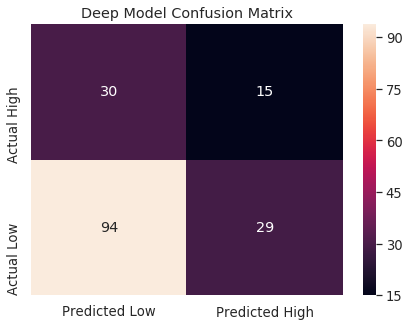

In [137]:
import seaborn as sn
import pandas as pd

fig, ax = plt.subplots()
fig.set_size_inches(7,5)
df_cm = pd.DataFrame(cm_test2, index = ['Actual Low','Actual High'],
                  columns = ['Predicted Low','Predicted High'])
sns.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, ax = ax)
ax.set_ylim([0,2]);
ax.set_title('Deep Model Confusion Matrix')
fig.savefig('DeepModel_CM.png')

## Profile after focal loss

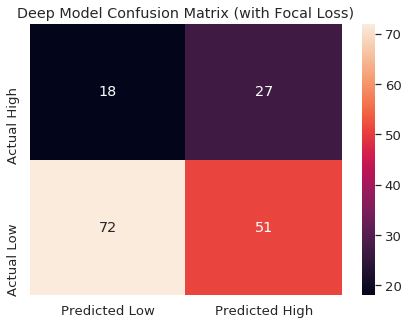

In [354]:
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots()
fig.set_size_inches(7,5)
df_cm = pd.DataFrame(cm_test, index = ['Actual Low','Actual High'],
                  columns = ['Predicted Low','Predicted High'])
sns.set(font_scale=1.2)
sns.heatmap(df_cm, annot=True, ax = ax)
ax.set_ylim([0,2]);
ax.set_title('Deep Model Confusion Matrix (with Focal Loss)');
fig.savefig('DeepModel_CM_Focal Loss.png')

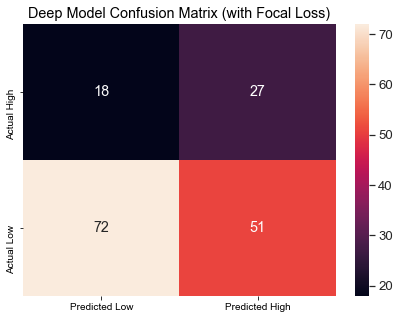

In [67]:
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots()
fig.set_size_inches(7,5)
df_cm = pd.DataFrame(cm_test, index = ['Actual Low','Actual High'],
                  columns = ['Predicted Low','Predicted High'])
sns.set(font_scale=1.2)
sns.heatmap(df_cm, annot=True, ax = ax)
ax.set_ylim([0,2]);
ax.set_title('Deep Model Confusion Matrix (with Focal Loss)');

In [69]:
testdf.head()

,predictions,age,sex,cough,fever,chills,sore_throat,headache,fatigue,urgency
0,Low,49.0,male,No,No,No,No,No,No,Low
1,Low,60.0,male,No,Yes,No,No,No,No,High
2,Low,41.0,male,Yes,Yes,No,Yes,No,No,Low
3,High,71.0,male,No,No,No,No,No,No,Low
4,Low,50.0,male,No,Yes,No,No,Yes,No,Low


In [72]:
row = testdf.iloc[0]

In [83]:
round(float(learn.predict(row[1:-1])[2][0]),5)

0.45702

## Experimental Section

Trying to figure out top 

In [84]:
for i in range(len(testdf)):
    row = testdf.iloc[i][1:]
    testdf.probability.iloc[i] = round(float(learn.predict(row[1:-1])[2][0]),5)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [119]:
testdf.head()

,predictions,probability,age,sex,cough,fever,chills,sore_throat,headache,fatigue,urgency
51,High,0.84191,96.0,female,Yes,Yes,No,No,No,No,Low
111,High,0.68008,13.0,female,No,Yes,No,No,No,No,Low
54,High,0.63708,20.0,female,No,No,No,No,No,No,Low
34,High,0.63283,18.0,male,No,No,No,No,No,No,High
151,High,0.63198,20.0,male,No,No,No,No,No,No,High


In [92]:
testdf.sort_values(by=['probability'],ascending = False, inplace = True)

In [ ]:
#
cumulative lift gain

baseline model - test 20%

In [ ]:
Cost based affection 

Give kits only top 20%

Profiling them:
How you can get the probs?
Decile?

subsetting your group - divide 100 people into ten equal groups
descending order of probability

profile them: see features (prediction important features)
    
top 20 vs rest 80

Descriptive statistics (count, mean, median, average)

How are they different? (see a big distinction top 20 top 80)

figure out what is happening



questions:
    
lift curve

    

In [ ]:
#

1. GET PROBABILITIES
2. MAKE DECILES
3. MAKE CURVE
4. PROFILING (feature selection - HOW ARE THEY BEHAVING??)

Optional:
    
Work with different thresholds

In [ ]:
Confusion matrix to risk matrix (cost what minimizes - risk utility matrix)

In [114]:
import scikitplot as skplt

In [129]:
y2 = y2.urgency

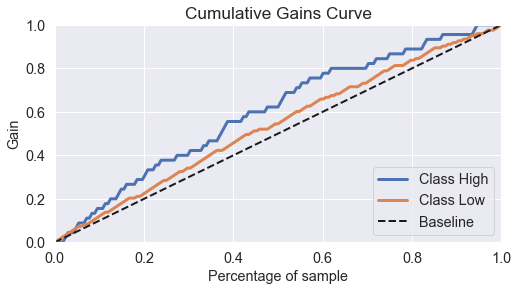

In [202]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
skplt.metrics.plot_cumulative_gain(y_true = testdf.urgency, y_probas= predicted_probas, ax=ax)
#    plt.savefig('lift_curve.png')

In [ ]:
df['decile1'] = pd.qcut(df['pred_prob'].rank(method='first'), 10, labels=np.arange(10, 0, -1))

In [259]:
lr_predicted_probas = []

for i in range(len(lr_df)):
    iprob = lr_df.iloc[i,0]
    lr_predicted_probas.append([round(iprob,4), round(1 - iprob,4)])

In [248]:
pickle_in = open('lg_predictions.pkl', 'rb')
lr_df = pickle.load(pickle_in)

In [294]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

In [305]:
plt.style.use('classic')

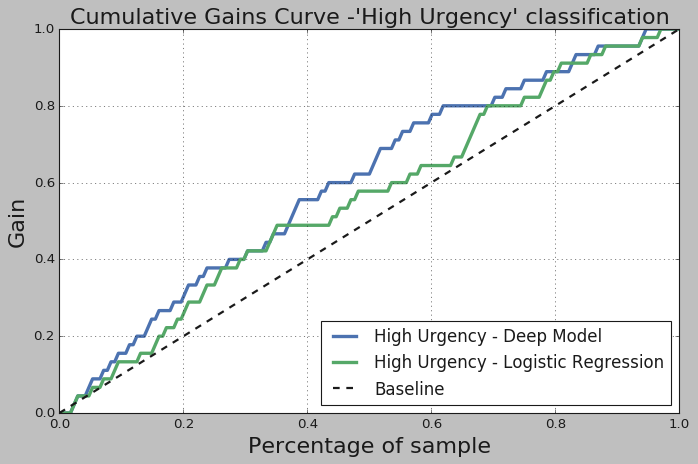

In [306]:
fig, ax = plt.subplots(figsize = (10,6))
classes = np.unique(np.array(testdf.urgency))
percentages, gains1 = skplt.metrics.cumulative_gain_curve(np.array(testdf.urgency), predicted_probas[:,0], classes[0])
percentages, gains2 = skplt.metrics.cumulative_gain_curve(np.array(lr_df.urgency), lr_predictions[:,0], classes[0])
ax.plot(percentages, gains1, lw=3, label = f'{classes[0]} Urgency - Deep Model')
ax.plot(percentages, gains2, lw=3, label = f'{classes[0]} Urgency - Logistic Regression')

ax.set_xlim([0.0,1.0])
ax.set_ylim([0.0,1.0])
ax.plot([0,1],[0,1], 'k--', lw =2, label = 'Baseline')

ax.grid('off')

ax.set_xlabel('Percentage of sample', fontsize=20)
ax.set_ylabel('Gain', fontsize=20)
ax.legend(loc = 'lower right', fontsize = 15)

ax.set_title("Cumulative Gains Curve -'High Urgency' classification", fontsize = 20)
fig.savefig('Cumulative Gains Chart')

In [204]:
os_data_y = testdf.urgency

In [207]:
os_data_y = os_data_y.to_frame()

In [212]:
os_data_y = os_data_y.urgency.map({'High':1, 'Low':0})

In [213]:
os_data_y = np.array(os_data_y)

## Profiling

In [281]:
testdf.head()


,predictions,probability,age,sex,cough,fever,chills,sore_throat,headache,fatigue,urgency
51,High,0.84191,96.0,female,Yes,Yes,No,No,No,No,Low
111,High,0.68008,13.0,female,No,Yes,No,No,No,No,Low
54,High,0.63708,20.0,female,No,No,No,No,No,No,Low
34,High,0.63283,18.0,male,No,No,No,No,No,No,High
151,High,0.63198,20.0,male,No,No,No,No,No,No,High


In [317]:
testdf['decile'] = pd.qcut(testdf.probability, q = 5, labels= False)

In [336]:
testdf[testdf.decile >2].fever.value_counts()

No     54
Yes    13
Name: fever, dtype: int64

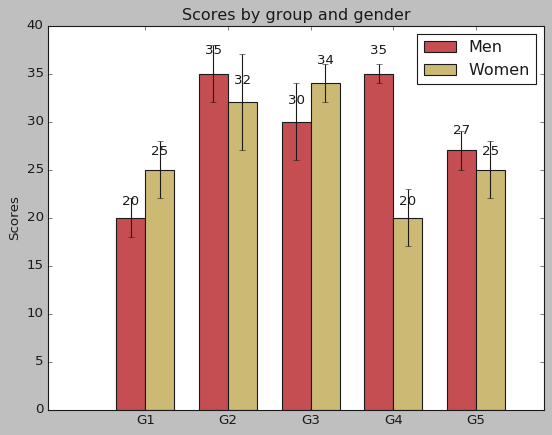